In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim
import torch.nn as nn

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [2]:
#reading a single file for denoising without additional features

fname_noisy = '/scratch0/CMSC740/nori-base-2019/scenes/pa4/veach_mi/veach_mats.png'
img_noisy_pil = crop_image(get_image(fname_noisy, imsize)[0], d=32)
img_noisy_np = pil_to_np(img_noisy_pil)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_loss_torch = img_noisy_torch
img_input_net = img_noisy_torch

In [2]:
def read_feature(file_name):
    _pil = crop_image(get_image(file_name, imsize)[0], d=32)
    _np = pil_to_np(_pil)
    return _pil, _np

In [8]:
scene = "bench1000"

In [232]:
# reading the input image and the ground truth
base = '/scratch0/CMSC740/denoising-data/'+scene+'/nfor-denoised.png' 
fname = base+scene+'/nfor-denoised.png'
fname_noisy = base+scene+'/color.png' 

img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil = crop_image(get_image(fname_noisy, imsize)[0], d=32)
img_noisy_np = pil_to_np(img_noisy_pil)

In [233]:
#reading the additional MC features
img_normal_pil, img_normal_np = read_feature(base+scene+'/normal.png')
img_na_pil, img_na_np = read_feature(base+scene+'/normalA.png')
img_nb_pil, img_nb_np = read_feature(bse+scene+'/normalB.png')
img_nv_pil, img_nv_np = read_feature(base+scene+'/normalVariance.png')

img_albedo_pil, img_albedo_np = read_feature(base+scene+'/albedo.png')
img_aa_pil, img_aa_np = read_feature(base+scene+'/albedoA.png')
img_ab_pil, img_ab_np = read_feature(base+scene+'/albedoB.png')
img_av_pil, img_av_np = read_feature(base+scene+'/albedoVariance.png')


img_depth_pil, img_depth_np = read_feature(base+scene+'/depth.png')
img_da_pil, img_da_np = read_feature(base+scene+'/depthA.png')
img_db_pil, img_db_np = read_feature(base+scene+'/depthB.png')
img_dv_pil, img_dv_np = read_feature(base+scene+'/depthVariance.png')

In [235]:
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
img_torch = np_to_torch(img_np).type(dtype)

img_normal_torch = np_to_torch(img_normal_np).type(dtype)
img_na_torch = np_to_torch(img_na_np).type(dtype)
img_nb_torch = np_to_torch(img_nb_np).type(dtype)
img_nv_torch = np_to_torch(img_nv_np).type(dtype)

img_albedo_torch = np_to_torch(img_albedo_np).type(dtype)
img_aa_torch = np_to_torch(img_aa_np).type(dtype)
img_ab_torch = np_to_torch(img_ab_np).type(dtype)
img_av_torch = np_to_torch(img_av_np).type(dtype)

img_depth_torch = np_to_torch(img_depth_np).type(dtype)
img_da_torch = np_to_torch(img_da_np).type(dtype)
img_db_torch = np_to_torch(img_db_np).type(dtype)
img_dv_torch = np_to_torch(img_dv_np).type(dtype)


img_concat_torch = torch.cat((img_noisy_torch, img_normal_torch, img_albedo_torch, img_depth_torch,
                             img_na_torch, img_nb_torch, img_aa_torch, img_ab_torch,
                             img_da_torch, img_db_torch, img_dv_torch, img_nv_torch, img_av_torch), 1)

#normals as input
#img_input_net = torch.cat((img_normal_torch, img_na_torch, img_nb_torch,img_nv_torch),1)
#depth as input
#img_input_net = torch.cat((img_depth_torch, img_da_torch, img_db_torch,img_dv_torch),1)
#albedos as input
#img_input_net = torch.cat((img_albedo_torch, img_aa_torch, img_ab_torch,img_av_torch),1)

#all MC features as input
img_input_net = img_concat_torch

img_loss_torch = img_noisy_torch # img_noisy_torch # img_concat_torch

In [10]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

net_type = "skip"
input_type = 'random' # allfeats_random random
method = "input"

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.001

out_depth = 3
if method == "loss":
    out_depth = img_loss_torch.shape[1]
output_features = 3

input_depth = img_input_net.shape[1]
if (input_type == "random"):
    input_depth = 3
elif input_type == "allfeats_random":
    input_depth += 3
    inflate_inner = 2

changed = False

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

inflate_inner = 1
num_channels_down_ = [8, 16, 32, 64, 128]
num_channels_up_   = [8, 16, 32, 64, 128]
num_channels_skip_ = [0, 0, 0, 4, 4]

num_iter = 3000
figsize = 5 
if net_type == "ResNet":
    net = ResNet(num_input_channels = input_depth, 
             num_output_channels = out_depth, 
             num_blocks=10, 
             num_channels=32, 
             need_sigmoid=False)
elif net_type == "skip":
    net = skip(
            input_depth, out_depth, 
            num_channels_down = [i*inflate_inner for i in num_channels_down_], 
            num_channels_up   = [i*inflate_inner for i in num_channels_up_],
            num_channels_skip = [i for i in num_channels_skip_], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
 
if (input_type == "allfeats"):
    net_input= img_input_net
elif (input_type == "random"):
    net_input = get_noise(3, INPUT, (img_noisy_pil.size[1], img_noisy_pil.size[0])).type(dtype).detach()
elif (input_type == "allfeats_random"):
    net_input1 = get_noise(3, INPUT, (img_noisy_pil.size[1], img_noisy_pil.size[0])).type(dtype).detach()    
    net_input = torch.cat((net_input1, img_input_net),1)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 572827


Starting optimization with ADAM


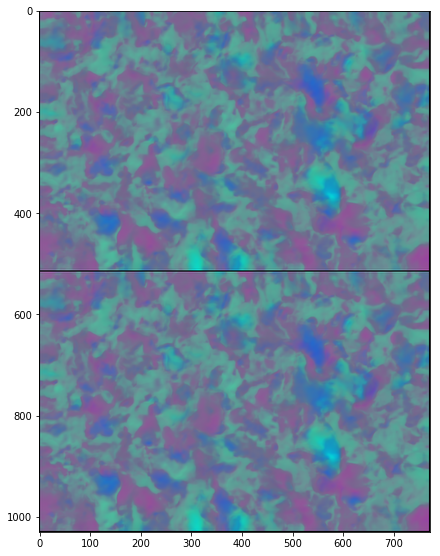

In [11]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
    
    total_loss = mse(out, img_loss_torch)
    total_loss.backward()
    psrn_noisy = compare_psnr(img_noisy_np, out[:,0:output_features,:,:].detach().cpu().numpy()[0]) 
    psrn_gt    = 1#compare_psnr(img_np, out[:,0:output_features,:,:].detach().cpu().numpy()[0]) 
    psrn_gt_sm = 1#compare_psnr(img_np, out_avg[:,0:output_features,:,:].detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np[0:3,:,:], 0, 1), 
                         np.clip(torch_to_np(out_avg)[0:3,:,:], 0, 1)], factor=figsize, nrow=1)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter, changed)

In [9]:
outnp = torch_to_np(net(net_input))
print(outnp.shape)
x =  512 # 1024 # 992 # 764
y = 768 # 1024 #1184 # 1280
R = outnp[0,:,:].reshape(x,y,1)
G = outnp[1,:,:].reshape(x,y,1)
B = outnp[2,:,:].reshape(x,y,1)
image = np.concatenate((np.concatenate((B,G),axis=2),R),axis=2)
if input_type == "random":
    cv2.imwrite("rest/"+scene+"_skip_noise3000.png", (255*image/(image.max())))
else:
    cv2.imwrite("rest/"+scene+"_skip_allfeats_noise3000.png", (255*image/(image.max())))

(3, 512, 768)


In [251]:
outnp = torch_to_np(out_avg)[0:3,:,:]
R = outnp[0,:,:].reshape(x,y,1)
#G = outnp[1,:,:].reshape(x,y,1)
#B = outnp[2,:,:].reshape(x,y,1)
image = R #np.concatenate((np.concatenate((B,G),axis=2),R),axis=2)
if input_type == "random":
    cv2.imwrite("rest/"+scene+"_skip_noise3000_avg.png", (255*image/(image.max())))
else:
    cv2.imwrite("rest/"+scene+"_skip_allfeats_noise3000_avg.png", (255*image/(image.max())))